# Task 3

## Forecast 1 day ahead

It is possible to complete this task using the sliding windows methodology and performing one-step-ahead forecasts.
We take the training data (e.g. 1 years, from T-365 to T), train the model on that period and forecast the next observation (let's say: T+1). Afterwards, we update the training data by inserting the real value from the test set which has been predicted and we discard the oldest data point (basically, we're shifting the training set of one day).

In [2]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, BatchNormalization, TimeDistributed
from keras.models import Model, Sequential

In [3]:
#os.chdir('C:\\Users\\loren\\xtreamassignment\\xtream-ai-assignment\\datasets\\italian-power-load')
load = 'load'
date = 'Date'

# define the column of interest
energy = 'Load'

# create the function to retrieve the data and set the date in a format that I prefer to work with (instead of uploadinf the dataset directly)

def retrieve_data(source):


    df = pd.read_csv((f"{source}.csv"), parse_dates = [date])

    df[date] = pd.to_datetime(df[date], utc=True, infer_datetime_format=True)

    df[date] = df[date].dt.strftime('%Y-%m-%d')

    df[date] = df[date].drop_duplicates()

    #df = df.sort_values(by=[date])

    df = df.set_index(pd.DatetimeIndex(df[date]))

    df = df.drop(columns=['Date'])

    return df

df = retrieve_data(load)

In [4]:
# Defining the plots for train/validation

def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs / Training RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs / Training Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color='red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [5]:
# I discard the yeras after 2019

data_task = df[:'2019']

In [6]:
# define the scalers that will be used
mms = MinMaxScaler(feature_range=(0,1))

In [7]:
# I'll use 2018 as validation, 2019 as test and the remaining years as training

# I create a function to scale the original dataset and perform some feature engineering
def create_scaled_array(df, selected_column, stop_year, your_scaler):

    # Define the number of train observations
    n_train = len(df) - len(df[stop_year:])

    # Create the array of the observations
    feature_array = df[selected_column].values.reshape(-1,1)

    # Scale the features: it's helpful when dealing with NN to prevent underfitting
    scaler = your_scaler

    scaler.fit(feature_array[:n_train])
    scaled_array = scaler.transform(feature_array)

    return scaled_array

In [8]:
# I write a function that creates sequences of data for the LSTM cell, since the network works differently from the MLP. 
# the function creates a list of lagged observation for each value in the y

def create_sequence(selected_array, lags):
    X, y = list(), list()
    for i in range(len(selected_array)):
        # find the end of this pattern
        end_ix = i + lags
        # check if we are beyond the sequence
        if end_ix > len(selected_array)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = selected_array[i:end_ix], selected_array[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
# I create a different scaled array since LSTM works better with minmax scaling

scaled_array = create_scaled_array(data_task, energy, '2018', mms)

In [11]:
# I create train, validation and test set using the previous function

X_train_lstm, y_train_lstm = create_sequence(scaled_array[:int(len(data_task)-732)], 7)
X_val_lstm, y_val_lstm = create_sequence(scaled_array[int(len(data_task)-732):int(len(data_task)-366)], 7)
X_test_lstm, y_test_lstm = create_sequence(scaled_array[int(len(data_task)-366):], 7)

In [15]:
lstm_test_rescaled = mms.inverse_transform(y_test_lstm)

In [23]:
# Define the hyperparamters of the NN

loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
EPOCHS = 200
batch = 16

In [24]:
input_shape1 = X_train_lstm.shape[-2:]

In [25]:
# I define the model, run it and make the predicitons as before

tf.keras.backend.clear_session()

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=input_shape1),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm.summary()

lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 10)             480       
                                                                 
 lstm_1 (LSTM)               (None, 7, 10)             840       
                                                                 
 flatten (Flatten)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 1,391
Trainable params: 1,391
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Now we choose the number of step ahead to do, in this case 1, and the sliding window size for the training phase

n_forecast_steps = 1  # This could be 1 if you want to predict one step at a time
window = 365*3

In [26]:
history_X = X_train_lstm.copy() # LA DIMENSIONE DEL TRAIN è DI 365*3 ORE -> 3 ANNI
history_y = y_train_lstm.copy()

predictions = [] # LIST OF PREDICTIONS
errors = [] # RMSE LIST
days = 1 # DAYS COUNTER
for i in range(0, len(X_test_lstm), n_forecast_steps):
    t_end = i + n_forecast_steps # BEGINNING FROM POSITION i OF THE TEST SET I INDICATE UP TO WHICH POSITION THE PREDICTIONS ARE MADE, OR EVERY DAY.
    
    if t_end > len(X_test_lstm):      
        t_end = len(X_test_lstm)
    X_test_block = X_test_lstm[i:t_end] # I TAKE THE TEST SET BLOCK ON WHICH TO FORECAST USING THE POSITIONS DECLARED EARLIER
    y_test_block = y_test_lstm[i:t_end]
    truth_block = lstm_test_rescaled[i:t_end]

    print('training and predicting for period', days)
    lstm.fit(history_X[-window:], history_y[-window:], validation_data=(X_val_lstm, y_val_lstm), epochs=100, verbose=0, batch_size=16, callbacks=[early_stopping]) # I DO WINDOW TRAINING USING 100 EPOCHS
                                                                                                         

    yhat = lstm.predict(X_test_block)                          # I MAKE THE PREDICTIONS AND RE-TRANSLATE THEM TO THE ORIGINAL SCALE
    yhat_rescaled = mms.inverse_transform(yhat)

    
    predictions.extend(yhat_rescaled)

    #print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

training and predicting for period 1
1/1 [==============================] - 1s 825ms/step
training and predicting for period 2
1/1 [==============================] - 0s 24ms/step
training and predicting for period 3
1/1 [==============================] - 0s 26ms/step
training and predicting for period 4
1/1 [==============================] - 0s 25ms/step
training and predicting for period 5
1/1 [==============================] - 0s 25ms/step
training and predicting for period 6
1/1 [==============================] - 0s 23ms/step
training and predicting for period 7
1/1 [==============================] - 0s 25ms/step
training and predicting for period 8
1/1 [==============================] - 0s 24ms/step
training and predicting for period 9
1/1 [==============================] - 0s 29ms/step
training and predicting for period 10
1/1 [==============================] - 0s 34ms/step
training and predicting for period 11
1/1 [==============================] - 0s 51ms/step
training and predi

In [27]:
rmse = sqrt(np.mean(lstm_test_rescaled - predictions)**2)
print('Mean Squared Error:', rmse)

Mean Squared Error: 3130.6991246518105


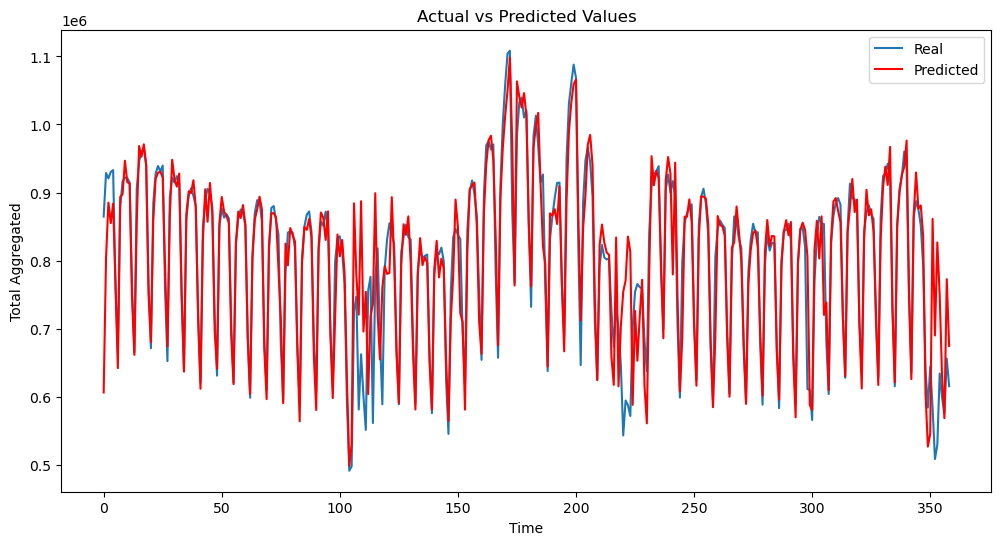

In [28]:
plot_preds_vs_actual(lstm_test_rescaled, predictions)

The one step ahead forecast allowed for better accuracy, as the model, updating the window of observation each time, was able to process better the patterns inside the data. This provided better forecasts for the following day, and general better perfomance, despite the computation time.